# Import required libraries and functions

In [13]:
import json
import matplotlib.pyplot as plt
from shapely.geometry import shape, Polygon, MultiPolygon
from shapely.strtree import STRtree
import networkx as nx
from networkx.readwrite import json_graph
import geojson
import logging

#  Neighbor list and precinct dual graph calculations

In [4]:
DEGREES_OF_LATITUDE_LONGITUDE_FOR_200_FEET = 0.000549450549
# 1 degree of latitude/longitude translates to ~364,000 feet, so setting up a proportion nets this number of degrees for 200 feet

geojson_file_paths = {
    "MD" : "states/maryland/geodata/maryland_precincts.geojson",
    "SC" : "states/south_carolina/geodata/south_carolina_precincts.geojson"
}
CHOSEN_STATE_TO_BE_GENERATED = "MD"
log_output_file_name = "preprocessing_precinct_graph_" + CHOSEN_STATE_TO_BE_GENERATED + ".log"
logging.basicConfig(filename=log_output_file_name, filemode='w', level=logging.DEBUG)

geojson_file = geojson_file_paths[CHOSEN_STATE_TO_BE_GENERATED]
with open(geojson_file, 'r') as f:
    geojson_data = json.load(f)

precincts_dual_graph = nx.Graph()

precincts = []
for feature in geojson_data['features']:
    unique_precinct_id = feature['properties']['UNIQUE_ID']
    precinct_geometry = shape(feature['geometry'])
    precinct_centroid_point = precinct_geometry.centroid
    precincts.append((unique_precinct_id, precinct_geometry, precinct_centroid_point))
    centroid_longitude = precinct_centroid_point.x
    centroid_latitude = precinct_centroid_point.y
    precincts_dual_graph.add_node(unique_precinct_id, center_point_longitude=centroid_longitude, center_point_latitude=centroid_latitude)

buffered_precinct_geometries = {}
for unique_precinct_id, precinct_geometry, _ in precincts:
   buffered_precinct_geometry = precinct_geometry.buffer(distance=DEGREES_OF_LATITUDE_LONGITUDE_FOR_200_FEET)
   buffered_precinct_geometries[unique_precinct_id] = buffered_precinct_geometry
   
buffered_precinct_geometries_for_tree = list(buffered_precinct_geometries.values())
precinct_geometry_str_tree = STRtree(buffered_precinct_geometries_for_tree)

index_to_precinct_id = {i: unique_precinct_id for i, (unique_precinct_id, _, _) in enumerate(precincts)}

for unique_precinct_id, precinct_geometry, _ in precincts:
    potential_neighboring_precincts = precinct_geometry_str_tree.query(precinct_geometry)
    logging.info("Potential neighbors:\n%s", potential_neighboring_precincts)
    for precinct_neighbor_index in potential_neighboring_precincts:
        neighbor_precinct_id = index_to_precinct_id[precinct_neighbor_index]
        neighbor_precinct_geometry = buffered_precinct_geometries[neighbor_precinct_id]
        logging.info("potential_neighboring_precincts[%s] = %s", precinct_neighbor_index,  neighbor_precinct_id)
        if unique_precinct_id != neighbor_precinct_id and precinct_geometry.intersects(neighbor_precinct_geometry):
            intersection = precinct_geometry.intersection(neighbor_precinct_geometry)
            logging.info("Boundary type: %s", intersection.geom_type)
            boundary = intersection.boundary
            logging.info("Boundary length: %s", boundary.length)
            if boundary.length >= DEGREES_OF_LATITUDE_LONGITUDE_FOR_200_FEET:
                precincts_dual_graph.add_edge(unique_precinct_id, neighbor_precinct_id)
                logging.info("Added edge between %s and %s", unique_precinct_id, neighbor_precinct_id)

logging.info("Graph created with %s nodes and %s edges", precincts_dual_graph.number_of_nodes(), precincts_dual_graph.number_of_edges())
graph_positions = {node: (data['center_point_longitude'], data['center_point_latitude']) for node, data in precincts_dual_graph.nodes(data=True)}
graph_json = json_graph.node_link_data(precincts_dual_graph)
output_file_name = "precinct_dual_graph_" + CHOSEN_STATE_TO_BE_GENERATED + ".json"
with open(output_file_name, "w") as f:
    json.dump(graph_json, f, indent=4)
logging.info("Graph saved to %s", output_file_name)
logging.shutdown()

#  Visual plot display of generated precinct graphs

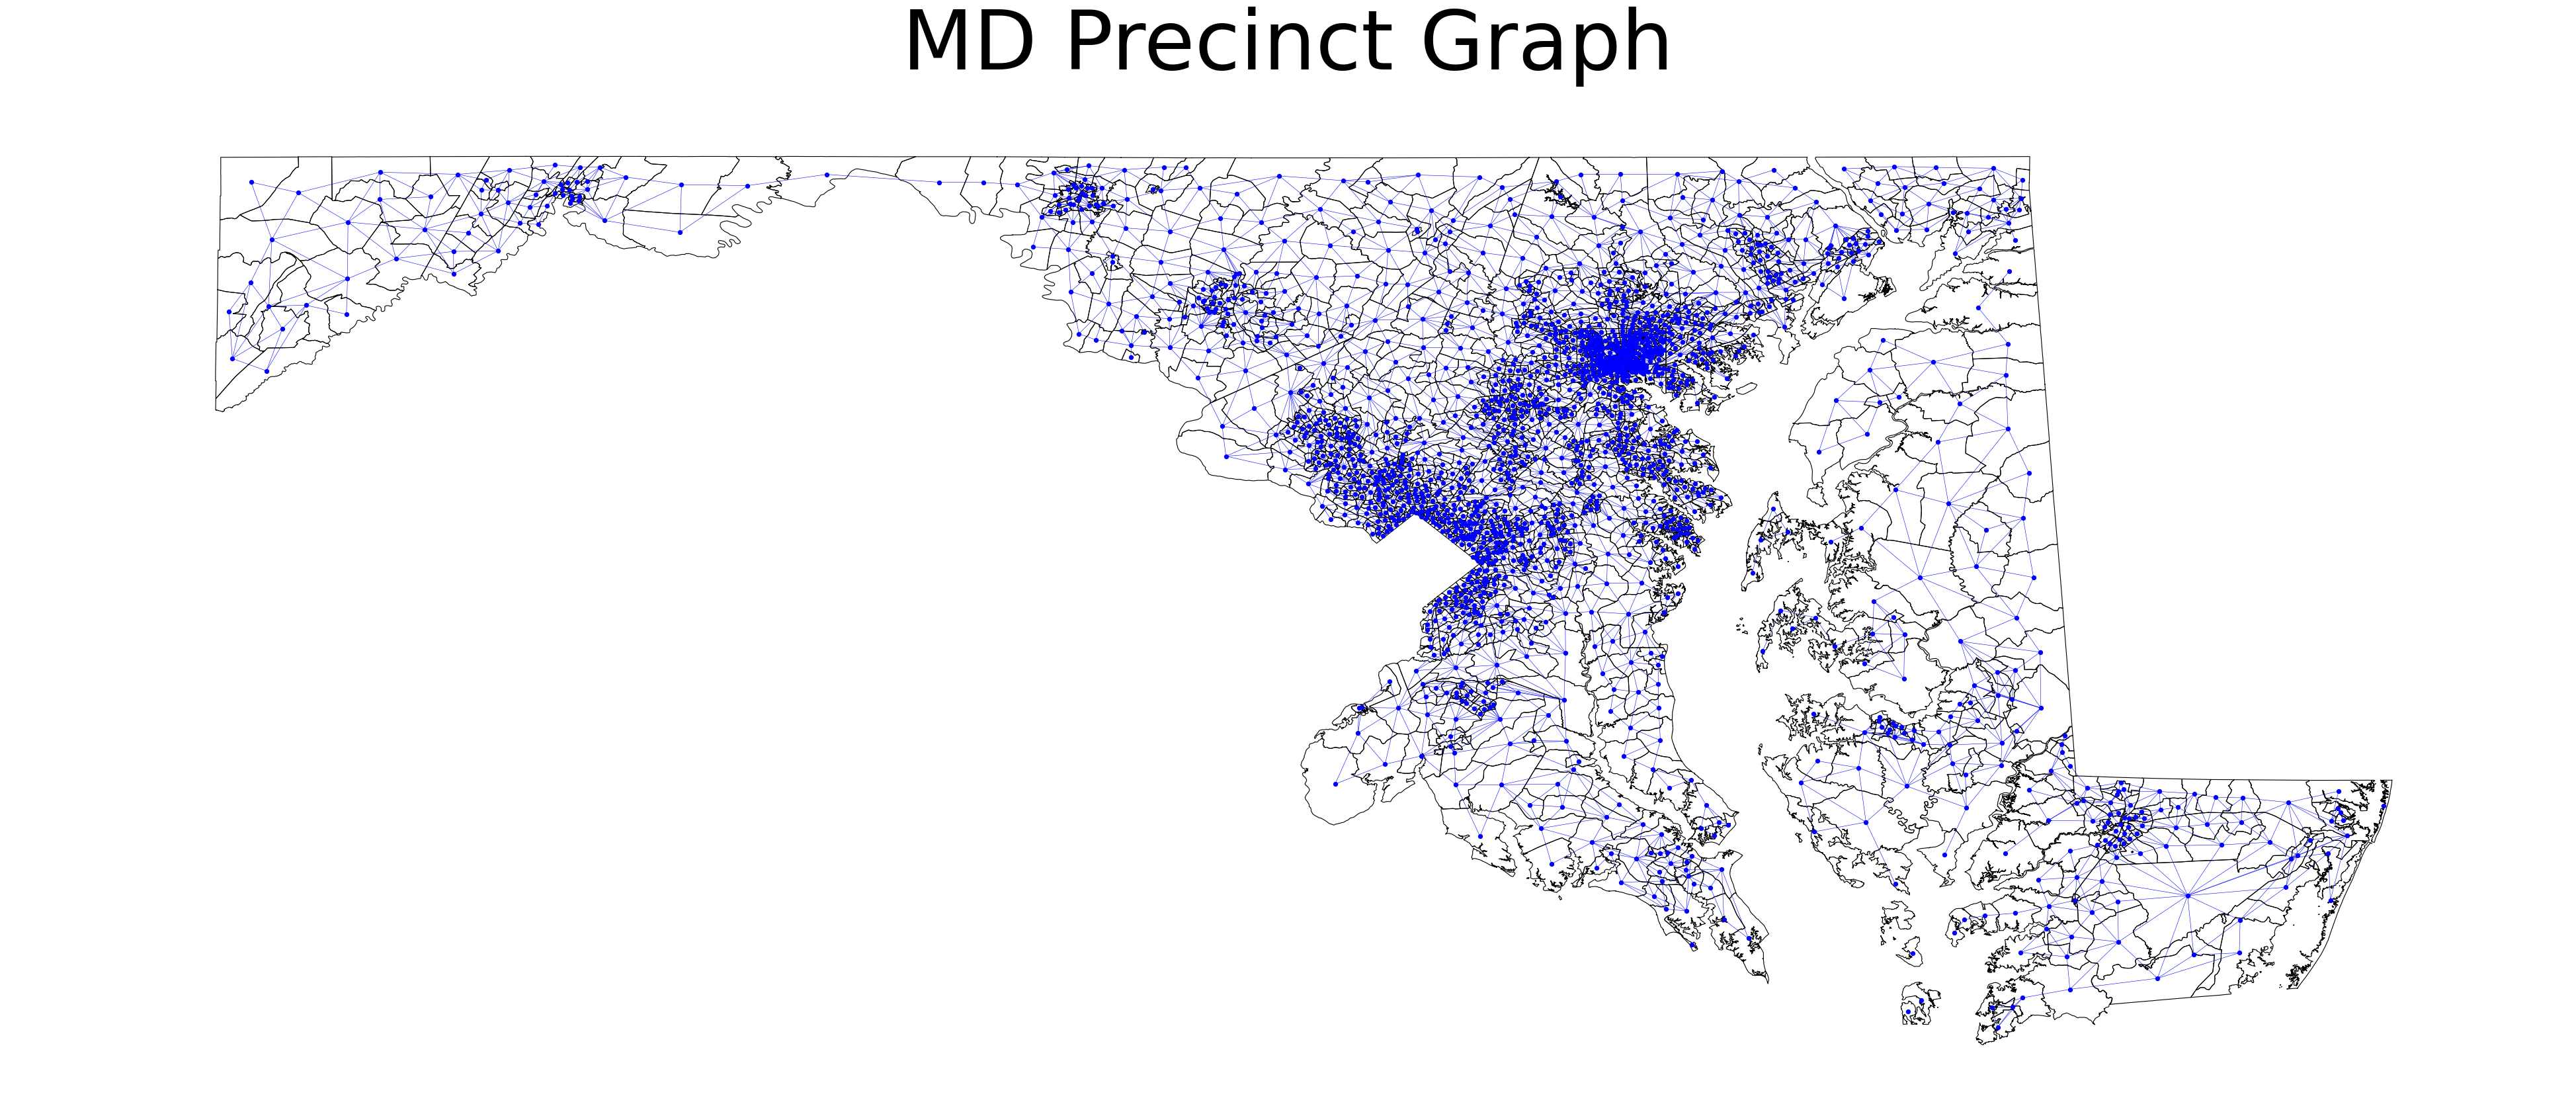

In [5]:
json_file_name = "precinct_dual_graph_" + CHOSEN_STATE_TO_BE_GENERATED + ".json"
NODE_COLOR = "blue"
OUTPUT_WITH_LABELS = False

with open(json_file_name, "r") as f:
    graph_data = json.load(f)

G = json_graph.node_link_graph(graph_data)

fig, ax = plt.subplots(figsize=(50,20))
for unique_precinct_id, geometry, _ in precincts:
    if isinstance(geometry, Polygon):
        x, y = geometry.exterior.xy  
        ax.plot(x, y, color="black", linewidth=0.8)
    elif isinstance(geometry, MultiPolygon):
        for polygon in geometry.geoms:
            x, y = polygon.exterior.xy
            ax.plot(x, y, color="black", linewidth=0.8)
nx.draw(
    G,
    pos=graph_positions,
    ax=ax,
    with_labels=OUTPUT_WITH_LABELS,
    node_size=18,
    node_color=NODE_COLOR,
    font_size=6,
    font_weight="bold",
    edge_color=NODE_COLOR,
    width=0.4
)
ax.set_aspect('equal', adjustable='datalim')
plot_label = CHOSEN_STATE_TO_BE_GENERATED + " Precinct Graph"
plt.title(label=plot_label, fontsize=90)
plt.title
plt.show()

#  Preparing precinct graph nodes for use in MGGG

In [ ]:
precinct_graph_file_paths = {
    "MD" : "precinct_dual_graph_MD_input.json",
    "SC" : "precinct_dual_graph_SC_input.json"
}
CHOSEN_STATE_TO_BE_GENERATED = "SC"
with open(precinct_graph_file_paths[CHOSEN_STATE_TO_BE_GENERATED]) as precinct_graph_file:
  precinct_graph_json = json.load(precinct_graph_file)
precinct_graph = json_graph.node_link_graph(precinct_graph_json)

with open(geojson_file_paths[CHOSEN_STATE_TO_BE_GENERATED]) as precinct_data_file:
  precinct_data_geojson = geojson.load(precinct_data_file)

features = precinct_data_geojson['features']

congressional_districts_2022 = {}
for feature in features:
  properties = feature.get('properties', {})
  congressional_districts_2022[properties.get("UNIQUE_ID")] = properties.get("CONG_DIST")

for node, data in precinct_graph.nodes(data=True):
  data["placement_2022"] = congressional_districts_2022[node]

updated_graph_data = json_graph.node_link_data(precinct_graph)
with open("precinct_dual_graph_SC_output.json", "w") as f:
    json.dump(updated_graph_data, f, indent=4)




TypeError: Object of type Graph is not JSON serializable